# Feature Engineering

The main objectives for this notebook are:
* Develop a set of features that have a potential to improve our model's performance
* Investiage the relationships between our new features and your target


## important steps 
1. Engineer a well argued feature (if with sources that's bonus point x2) 
2. Validate features after engineering
3. Don't use blind (auto) feature engineering - waste of time
    - Irrelevant Features Can Reduce Model Performance
    - Difficulty in Model Interpretability and Explainability
    - Lack of Alignment with Business Goals
4. Design a feature engineering pipeline at the end of the notebook

# Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection

import polars as pl

# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

from feature_engineering import (
    aggregate_node_features,
    feature_predictive_power,
    get_graph_features,
)

pio.renderers.default = "notebook"

In [2]:
data = pl.read_parquet('../data/supervised_clean_data.parquet')
calls = pl.read_json('../data/supervised_call_graphs.json')

In [3]:
data.head(1)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool
0,"""1f2c32d8-2d6e-3b68-bc46-789469…",0.000812,0.004066,85.643243,5405,"""default""",1460.0,1295.0,451.0,"""E""","""normal""",false


In [4]:
calls.head(1)

_id,call_graph
str,list[struct[2]]
"""1f2c32d8-2d6e-3b68-bc46-789469…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""8955faa9-0e33-37ad-a1dc-f0e640a114c2"",""a4fd6415-1fd4-303e-aa33-bb1830b5d9d4""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"


Since the main dataset already contains engineered features, there's not much opportunity to do feature engineering there. So, additional features will be created using the graph data that comes from `supervised_call_graphs.json`

## Process Graph Data

In [5]:
calls_processed = (
    calls.with_columns(
        pl.col("call_graph").list.eval(
            pl.element().struct.rename_fields(["from", "to"])
        )
    )
    .explode("call_graph")
    .unnest("call_graph")
)

calls_processed.head()

_id,from,to
str,str,str
"""1f2c32d8-2d6e-3b68-bc46-789469…","""1f873432-6944-3df9-8300-8a3cf9…","""5862055b-35a6-316a-8e20-3ae20c…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""8955faa9-0e33-37ad-a1dc-f0e640…","""a4fd6415-1fd4-303e-aa33-bb1830…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""85754db8-6a55-30b7-8558-dec75f…","""85754db8-6a55-30b7-8558-dec75f…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""9f08fee1-953c-3801-b254-c0256f…","""876b4958-7df1-3b2b-9def-1a22f1…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""857c4b20-3057-30e0-9ca3-d6f5c3…","""857c4b20-3057-30e0-9ca3-d6f5c3…"


## Feature Engineering

We can see that each graph has a separate `_id` that can be later used to join to the main dataset. A graph consistst out of `source` and `destination` nodes which refer to the available API calls.

### Basic Graph Level Features

The most basic graph-level that we can engineer are:
* Number of edges (connections)
* Number of nodes (APIs)

These features can be useful since most behaviours are going to have a "normal" range of APIs that they contact. If this number is too large or too small, this might be an indication of anomalous activity.

In [17]:
graph_features = calls_processed.group_by('_id').agg(
    pl.len().alias('n_connections'),
    pl.col('from'),
    pl.col('to')
).with_columns(
    pl.concat_list('to', 'from').list.unique().list.len().alias('n_unique_nodes')
).select([
    '_id',
    'n_connections',
    'n_unique_nodes'
])

graph_features.sample(3)

_id,n_connections,n_unique_nodes
str,u32,u32
"""270c4cd6-3c4a-3cf9-a99f-30c290…",15,15
"""cb8e40ee-a935-30ba-8071-9ced09…",319,114
"""ffa46dee-4173-310d-b671-8cc4bb…",2,2


### Node Level Features

Since graphs consist out of nodes, we can engineer a set of features around specific nodes (APIs). We can calculate:

* Node degrees -  the number of edges that come from/into a node. Very highly connected nodes can look anomalous.
* Node centrality - there are various centrality measures (e.g. Page Rank) but they all try to estimate how important to the whole graph is a specific node. This feature could be useful because a behaviour pattern that doesn't touch any of the "central" APIs would look anomalous


These features can be broken down into:
* **global** features - measure node attributes across all the graphs
* **local**  features - measure node attributes across a specific graph


In [18]:
calls_processed = calls_processed.with_columns(
    global_source_degrees = pl.len().over(pl.col('from')),
    global_dest_degrees = pl.len().over(pl.col('to')),
    local_source_degrees = pl.len().over(pl.col('from'), pl.col('_id')),
    local_dest_degrees = pl.len().over(pl.col('to'), pl.col('_id'))
)

calls_processed.sample(3)

_id,from,to,global_source_degrees,global_dest_degrees,local_source_degrees,local_dest_degrees
str,str,str,u32,u32,u32,u32
"""41b256e2-7623-3802-9c5f-5e7dbd…","""07d688eb-153b-3aa7-9151-f72f66…","""78aef349-54e8-32ad-9370-6bb1d0…",1379,750,3,2
"""85150ce4-93bc-3ad6-8fbd-2b1059…","""0dcce33b-ffcc-3d08-ad4e-748523…","""dcb46cd0-f074-394e-88d0-fc34a6…",8281,119,4,1
"""ca8de54f-8feb-3e9f-b68e-d45034…","""efffe404-32e9-3549-9873-c734f9…","""90a655af-9f52-35a2-afc8-5a6ead…",10582,3627,26,10


Now that the node-level features are calculated, we need to aggregate them for a specific graph (`_id`). When aggregating, we can calcualte average, std, min, and max statistics for every feature to capture the distribution well.

In [19]:
node_features_agg = aggregate_node_features(
    calls_processed,
    node_features=[
        "global_source_degrees",
        "global_dest_degrees",
        "local_source_degrees",
        "local_dest_degrees",
    ],
    by="_id",
)

graph_features = graph_features.join(node_features_agg, on="_id")
graph_features.head()


_id,n_connections,n_unique_nodes,avg_global_source_degrees,min_global_source_degrees,max_global_source_degrees,std_global_source_degrees,avg_global_dest_degrees,min_global_dest_degrees,max_global_dest_degrees,std_global_dest_degrees,avg_local_source_degrees,min_local_source_degrees,max_local_source_degrees,std_local_source_degrees,avg_local_dest_degrees,min_local_dest_degrees,max_local_dest_degrees,std_local_dest_degrees
str,u32,u32,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64
"""05761a26-ebf9-3aad-bdb7-eb77a5…",1084,222,5613.247232,6,32071,7733.082672,6172.901292,3,22416,7089.345652,16.418819,1,71,19.057425,17.693727,1,60,17.825364
"""c8acc277-96bf-3e23-aecd-fa6cec…",140,50,6185.378571,146,32071,8742.234697,6734.242857,182,22416,7276.324421,5.2,1,13,3.416422,6.528571,1,16,4.786737
"""cf3ebfff-a72b-3958-b863-e85de3…",15,10,4703.6,403,32071,8086.778679,7053.2,813,22416,9074.72764,1.933333,1,3,0.703732,1.8,1,3,0.774597
"""3772f247-29b6-3107-88fb-6965cc…",154,36,8382.461039,158,32071,8761.949929,9516.0,521,22416,7771.593224,7.571429,1,17,4.486519,8.324675,1,21,5.776766
"""88657ed6-d1a6-345f-9072-badb46…",24,17,287.708333,9,596,219.72146,522.875,7,1151,458.418578,2.25,1,5,1.594829,3.25,1,6,2.211629


## Feature Selection
Feature selection will be done using 2 steps:
1. Quality checks - if the feature is constant or has too many missing values (>= 95%) it will be dropped
2. Correlation analysis - if features have very high correlation (>= 95%) with each other, they can be dropped as well

In [20]:
engineered_features = graph_features.columns[1:]
engineered_features

['n_connections',
 'n_unique_nodes',
 'avg_global_source_degrees',
 'min_global_source_degrees',
 'max_global_source_degrees',
 'std_global_source_degrees',
 'avg_global_dest_degrees',
 'min_global_dest_degrees',
 'max_global_dest_degrees',
 'std_global_dest_degrees',
 'avg_local_source_degrees',
 'min_local_source_degrees',
 'max_local_source_degrees',
 'std_local_source_degrees',
 'avg_local_dest_degrees',
 'min_local_dest_degrees',
 'max_local_dest_degrees',
 'std_local_dest_degrees']

### Quality Checks

In [21]:
null_counts = graph_features.null_count().transpose(include_header=True, header_name='col', column_names=['null_count'])
null_counts.filter(pl.col('null_count') > 0)

col,null_count
str,u32
"""std_global_source_degrees""",42
"""std_global_dest_degrees""",42
"""std_local_source_degrees""",42
"""std_local_dest_degrees""",42


In [22]:
static_features = graph_features.select(engineered_features).std().transpose(include_header=True, header_name='col', column_names=['std'])
static_features.filter(pl.col('std') == 0)

col,std
str,f64


**Observations:**
* 4 columns have missing values. All of them calculate standard deviation

**Impact**
* No features will be dropped for quality reasons

### Correlation Analysis

As we can see, global degrees

<Axes: >

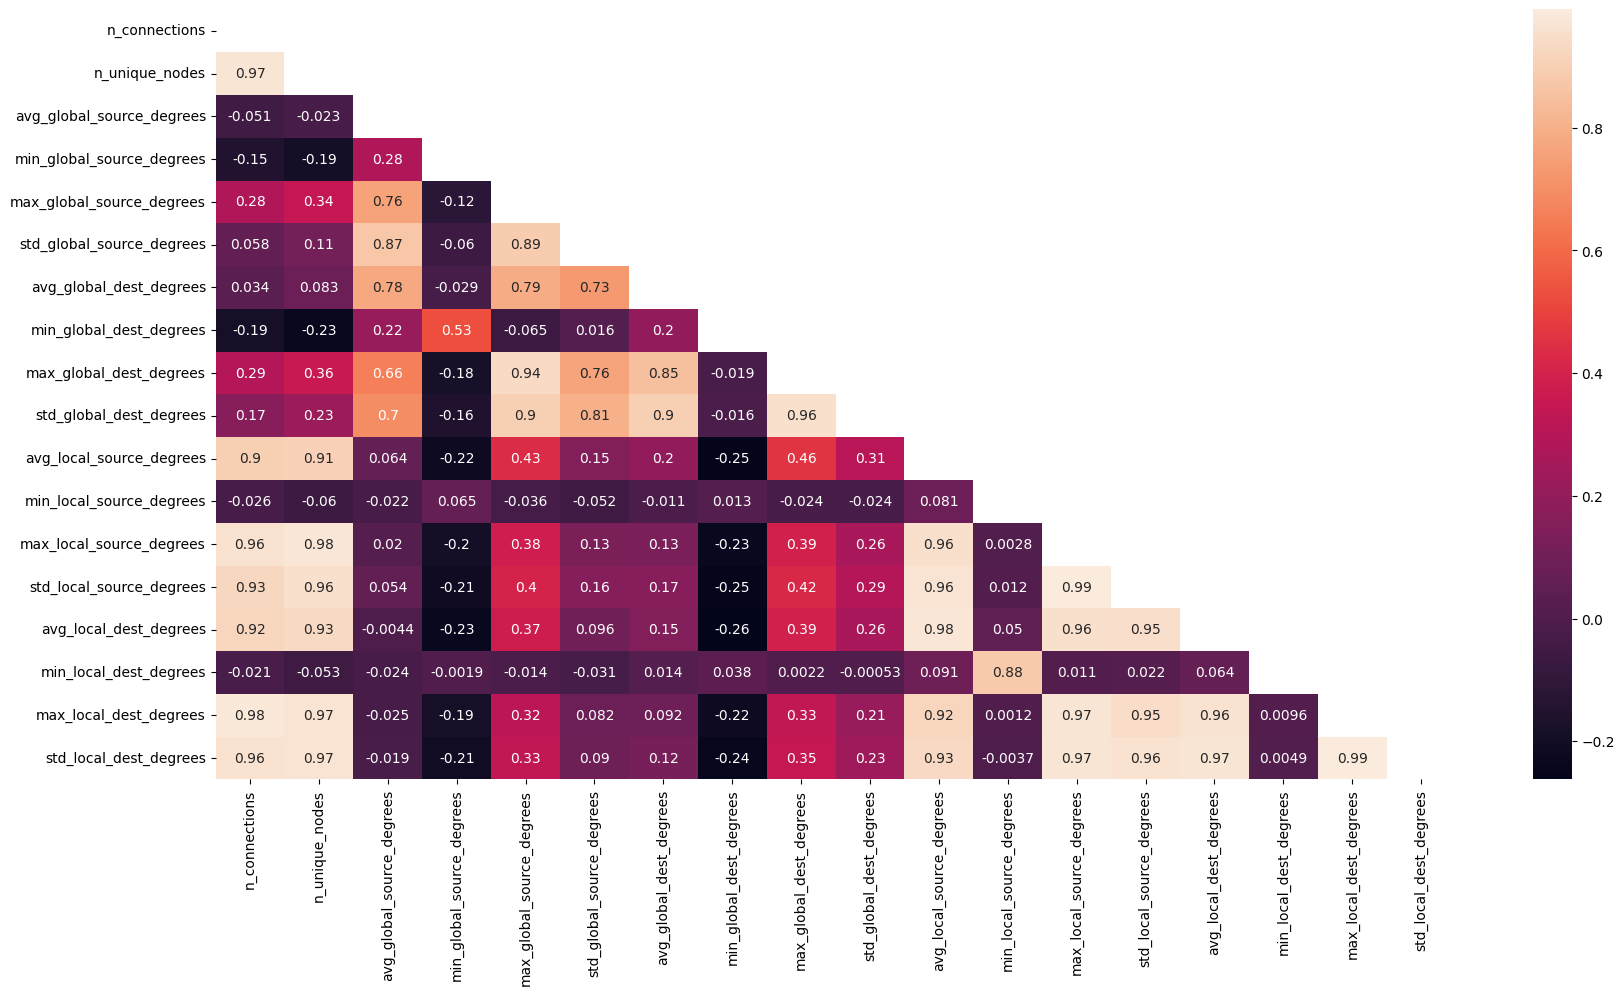

In [23]:
feature_corrs = graph_features.select(engineered_features).to_pandas().dropna().corr()
feature_corrs.index = feature_corrs.columns
matrix = np.triu(feature_corrs)
fig = plt.figure(figsize=(20, 10))
sns.heatmap(feature_corrs, annot=True, mask=matrix)

We can see clear groups of highyl correlated features. Hence, let's apply `SmartCorrelatedSelection` to reduce the feature set of engineered features

In [24]:
features_pd = graph_features.select(engineered_features).to_pandas().dropna()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.95,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

tr.fit(features_pd)

print('Features to drop:')
for f in tr.features_to_drop_:
    print(f)

Features to drop:
std_global_dest_degrees
n_unique_nodes
max_local_source_degrees
max_local_dest_degrees
std_local_dest_degrees
avg_local_dest_degrees
avg_local_source_degrees


**Observations:**
* Engineered features have groups of high correlation

**Impact**
* `['n_unique_nodes', 'std_global_dest_degrees', 'avg_local_source_degrees', 'max_local_source_degrees', 'avg_local_dest_degrees', 'max_local_dest_degrees' 'std_local_dest_degrees']` are dropped from the features list due to belonging to a high correlation set and having lower variance than the remaining feature

## EDA for Remaining Engineered Features

In [25]:
remaining_engineered_features = list(set(features_pd).difference(set(tr.features_to_drop_)))
graph_features = graph_features.join(data.select(['_id', 'is_anomaly']),  on='_id')

In [26]:
scores = []
for f in remaining_engineered_features:
    print("Feature Analysis:", f)
    score = feature_predictive_power(graph_features, f, "is_anomaly")
    scores.append(score)

Feature Analysis: max_global_source_degrees
Predictive Power Score: 0.36739999055862427


Feature Analysis: std_local_source_degrees
Predictive Power Score: 0.5327000021934509


Feature Analysis: min_global_source_degrees
Predictive Power Score: 0.5494999885559082


Feature Analysis: min_global_dest_degrees
Predictive Power Score: 0.5932000279426575


Feature Analysis: avg_global_source_degrees
Predictive Power Score: 0.328900009393692


Feature Analysis: n_connections
Predictive Power Score: 0.5871999859809875


Feature Analysis: avg_global_dest_degrees
Predictive Power Score: 0.3370000123977661


Feature Analysis: std_global_source_degrees
Predictive Power Score: 0.44369998574256897


Feature Analysis: max_global_dest_degrees
Predictive Power Score: 0.5921000242233276


Feature Analysis: min_local_dest_degrees
Predictive Power Score: 0.007799999788403511


Feature Analysis: min_local_source_degrees
Predictive Power Score: 0.0


In [27]:
pd.Series(scores, index=remaining_engineered_features).sort_values(ascending=False)

min_global_dest_degrees      0.5932
max_global_dest_degrees      0.5921
n_connections                0.5872
min_global_source_degrees    0.5495
std_local_source_degrees     0.5327
std_global_source_degrees    0.4437
max_global_source_degrees    0.3674
avg_global_dest_degrees      0.3370
avg_global_source_degrees    0.3289
min_local_dest_degrees       0.0078
min_local_source_degrees     0.0000
dtype: float32

**Observations:**
* Most of the engineered features have relatively highe predictiveness score
* The most predictive features are `global`
* Features with no predictive power measure minimum degrees of local graphs
* Relationships between engineered features and the target are not-linear

**Impact**
* `min_local_dest_degrees` and `min_local_source_degrees` can be dropped
* Tree based models need to be used to capture the engineered relationships 

In [28]:
remaining_engineered_features = [f for f in remaining_engineered_features if f not in ['min_local_dest_degrees', 'min_local_source_degrees']]
print('Final engineered featureset:')
print(remaining_engineered_features)

Final engineered featureset:
['max_global_source_degrees', 'std_local_source_degrees', 'min_global_source_degrees', 'min_global_dest_degrees', 'avg_global_source_degrees', 'n_connections', 'avg_global_dest_degrees', 'std_global_source_degrees', 'max_global_dest_degrees']
